# Walmart Sales Analysis

We want to understand what drives sales in Walmart stores. 
Business questions:
- How do holidays impact weekly sales?
- Does air temperature affect consumer spending?
- Which stores perform best over time?
- Are there seasonal trends or patterns in sales?
- Do fuel prices, CPI, and unemployment influence revenue?

In [1]:
# --- Library Imports ---
import sys
import platform
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import statsmodels.api as sm

# --- Version & Environment Info ---
print("="*50)
print("📦 Environment & Library Versions")
print("="*50)
print(f"Python version:     {sys.version.split()[0]}")
print(f"Platform:           {platform.platform()}")
print(f"pandas:             {pd.__version__}")
print(f"numpy:              {np.__version__}")
print(f"matplotlib:         {plt.matplotlib.__version__}")
print(f"seaborn:            {sns.__version__}")
print(f"statsmodels:        {sm.__version__}")
print(f"kagglehub:          {kagglehub.__version__}")
print("="*50)

📦 Environment & Library Versions
Python version:     3.13.4
Platform:           Windows-11-10.0.26100-SP0
pandas:             2.3.1
numpy:              2.3.1
matplotlib:         3.10.7
seaborn:            0.13.2
statsmodels:        0.14.5
kagglehub:          0.3.13


In [2]:
# load data
pd.options.display.float_format = '{:,.0f}'.format
df = pd.read_csv(r".\data\walmart_sales_data.csv")
df['Store'] = df['Store'].astype('category')
df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')
df['Temp_Bin'] = pd.Categorical(df['Temp_Bin'], 
                                categories=['Cold', 'Mild', 'Warm', 'Hot'], 
                                ordered=True)

In [3]:
# data check
print(df.head())
print(df.info())

  Store        Date  Weekly_Sales Holiday_Flag  Temperature  Fuel_Price  CPI  \
0     1  2010-02-05     1,643,691            0           42           3  211   
1     1  2010-02-12     1,641,957            1           39           3  211   
2     1  2010-02-19     1,611,968            0           40           3  211   
3     1  2010-02-26     1,409,728            0           47           3  211   
4     1  2010-03-05     1,554,807            0           46           3  211   

   Unemployment  Year  Month  Week  DayOfWeek     Holiday  Sales_3week_MA  \
0             8  2010      2     5          4  No Holiday       1,643,691   
1             8  2010      2     6          4     Holiday       1,642,824   
2             8  2010      2     7          4  No Holiday       1,632,539   
3             8  2010      2     8          4  No Holiday       1,554,551   
4             8  2010      3     9          4  No Holiday       1,525,501   

   Sales_12week_MA Temp_Bin  Season  zscore_sales  is_ou

## Question 1 How do holidays impact weekly sales?

In [4]:
# Compare average sales for holiday vs non-holiday weeks
holiday_impact = (
    df.groupby('Holiday', observed=True)['Weekly_Sales']
      .agg(['mean', 'median', 'std', 'sum', 'count'])
      .reset_index()
      .rename(columns={
          'mean': 'Avg_Sales',
          'median': 'Median_Sales',
          'std': 'Std_Dev',
          'sum': 'Total_Sales',
          'count': 'Num_Weeks'
      })
)
print(holiday_impact)

      Holiday  Avg_Sales  Median_Sales  Std_Dev   Total_Sales  Num_Weeks
0     Holiday  1,122,888     1,018,538  627,685   505,299,552        450
1  No Holiday  1,041,256       956,211  558,957 6,231,919,436       5985


In [5]:
holiday_diff = (
    (holiday_impact.loc[holiday_impact['Holiday'] == 'Holiday', 'Avg_Sales'].values[0] /
     holiday_impact.loc[holiday_impact['Holiday'] == 'No Holiday', 'Avg_Sales'].values[0] - 1) * 100
)
print(f"Holiday weeks have {holiday_diff:.2f}% higher average sales than non-holiday weeks.")

Holiday weeks have 7.84% higher average sales than non-holiday weeks.


In [6]:
# Compare average sales for holiday vs non-holiday weeks by Store
holiday_by_store = (
    df.groupby(['Store','Holiday'], observed=True)['Weekly_Sales']
      .mean()
      .unstack(fill_value=np.nan)
      .reset_index()
)
holiday_by_store[['Holiday','No Holiday']] = holiday_by_store[['Holiday','No Holiday']].fillna(0)
holiday_by_store['Diff_%'] = (
    (holiday_by_store['Holiday'] - holiday_by_store['No Holiday']) /
    holiday_by_store['No Holiday'].replace(0, np.nan) * 100
).fillna(0)

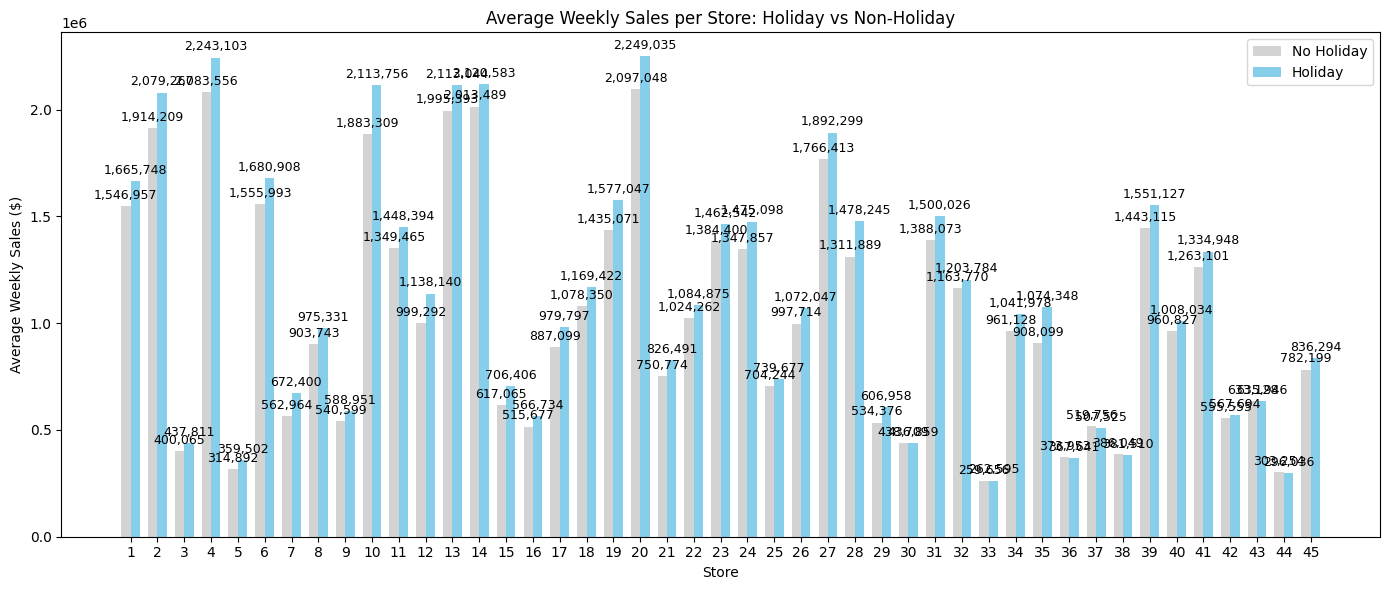

In [7]:
x = np.arange(len(holiday_by_store['Store']))
width = 0.35
fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, holiday_by_store['No Holiday'], width, 
               label='No Holiday', color='lightgray')
bars2 = ax.bar(x + width/2, holiday_by_store['Holiday'], width, 
               label='Holiday', color='skyblue')
ax.set_xlabel('Store')
ax.set_ylabel('Average Weekly Sales ($)')
ax.set_title('Average Weekly Sales per Store: Holiday vs Non-Holiday')
ax.set_xticks(x)
ax.set_xticklabels(holiday_by_store['Store'])
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,.0f}',  # format angka pakai koma ribuan
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset sedikit ke atas
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='black')
add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()

## Question 2 Does air temperature affect consumer spending?

In [8]:
# Calculate average weekly sales per temperature bin
temp_sales = (
    df.groupby('Temp_Bin', observed=True)['Weekly_Sales']
      .mean()
      .reset_index()
      .sort_values('Temp_Bin')
)
print(temp_sales)

  Temp_Bin  Weekly_Sales
0     Cold     1,081,396
1     Mild     1,071,085
2     Warm     1,059,193
3      Hot       942,057


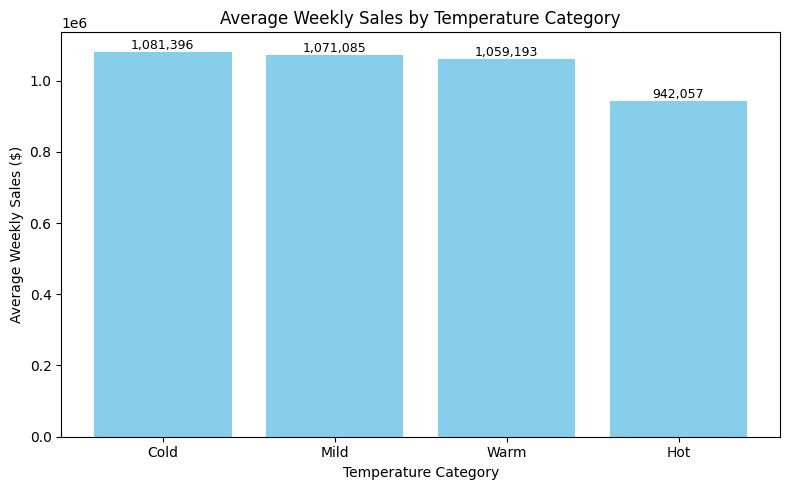

In [9]:
plt.figure(figsize=(8,5))
bars = plt.bar(temp_sales['Temp_Bin'], temp_sales['Weekly_Sales'], color='skyblue')
plt.title('Average Weekly Sales by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Average Weekly Sales ($)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval:,.0f}',  # Format ribuan tanpa desimal
             ha='center', va='bottom', fontsize=9, color='black')
plt.tight_layout()
plt.show()

In [10]:
corr = df[['Weekly_Sales', 'Temperature']].corr().iloc[0,1]
print(f"Correlation between Temperature and Weekly Sales: {corr:.3f}")

Correlation between Temperature and Weekly Sales: -0.064


## Question 3 Which stores perform best over time?

In [11]:
# Aggregate total and average sales by store
store_performance = (
    df.groupby('Store', observed=True)
      .agg(
          Total_Sales=('Weekly_Sales', 'sum'),
          Average_Weekly_Sales=('Weekly_Sales', 'mean'),
          Std_Weekly_Sales=('Weekly_Sales', 'std')
      )
      .reset_index()
      .sort_values(by='Total_Sales', ascending=False)
)

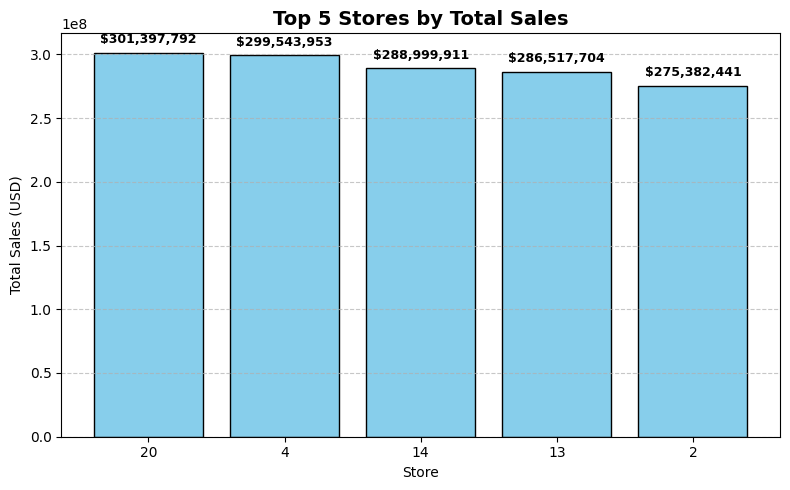

In [12]:
store_performance['Total_Sales'] = store_performance['Total_Sales'].replace(',', '', regex=True).astype(float)
store_performance['Average_Weekly_Sales'] = store_performance['Average_Weekly_Sales'].replace(',', '', regex=True).astype(float)
top5_sales = store_performance.head(5)
plt.figure(figsize=(8,5))
bars = plt.bar(
    top5_sales['Store'].astype(str),
    top5_sales['Total_Sales'],
    color='skyblue',
    edgecolor='black'
)
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 5000000,  # sedikit di atas bar
        f"${yval:,.0f}",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )
plt.title('Top 5 Stores by Total Sales', fontsize=14, fontweight='bold')
plt.xlabel('Store')
plt.ylabel('Total Sales (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
store_trend = (
    df.groupby(['Store', 'Year', 'Month'], observed=True)['Weekly_Sales']
      .sum()
      .reset_index()
      .sort_values(['Store', 'Year', 'Month'])
)

In [14]:
store_growth = (
    store_trend.groupby('Store', observed=True)['Weekly_Sales']
    .apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
    .reset_index(name='Growth_%')
    .sort_values(by='Growth_%', ascending=False)
)

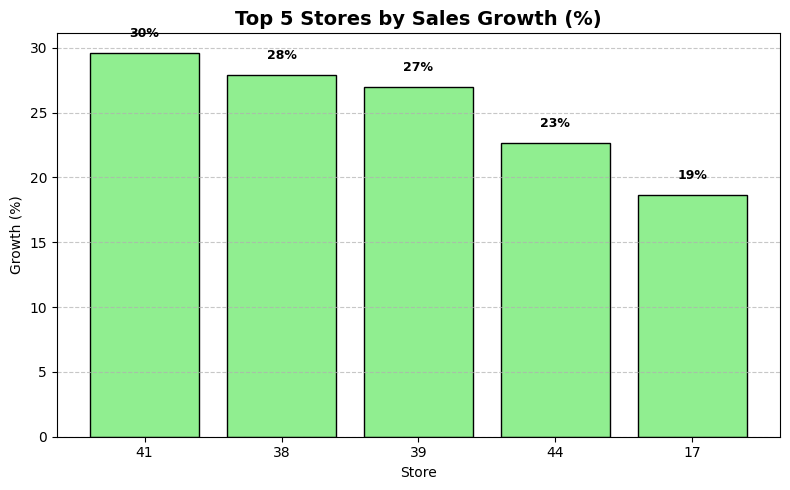

In [15]:
store_growth['Growth_%'] = store_growth['Growth_%'].astype(float)
top5_growth = store_growth.head(5)
plt.figure(figsize=(8,5))
bars = plt.bar(
    top5_growth['Store'].astype(str),
    top5_growth['Growth_%'],
    color='lightgreen',
    edgecolor='black'
)
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 1,  # jarak sedikit
        f"{yval:.0f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )
plt.title('Top 5 Stores by Sales Growth (%)', fontsize=14, fontweight='bold')
plt.xlabel('Store')
plt.ylabel('Growth (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Question 4 Are there seasonal trends or patterns in sales?

In [16]:
# Aggregate average weekly sales per month across all stores
seasonal_trends = (
    df.groupby(['Year', 'Month'], observed=True)['Weekly_Sales']
      .mean()
      .reset_index()
      .sort_values(['Year', 'Month'])
)
seasonal_trends['Month_Name'] = seasonal_trends['Month'].apply(
    lambda x: pd.to_datetime(str(x), format='%m').strftime('%b')
)
print(seasonal_trends.head())

   Year  Month  Weekly_Sales Month_Name
0  2010      2     1,057,405        Feb
1  2010      3     1,010,666        Mar
2  2010      4     1,028,499        Apr
3  2010      5     1,037,283        May
4  2010      6     1,068,034        Jun


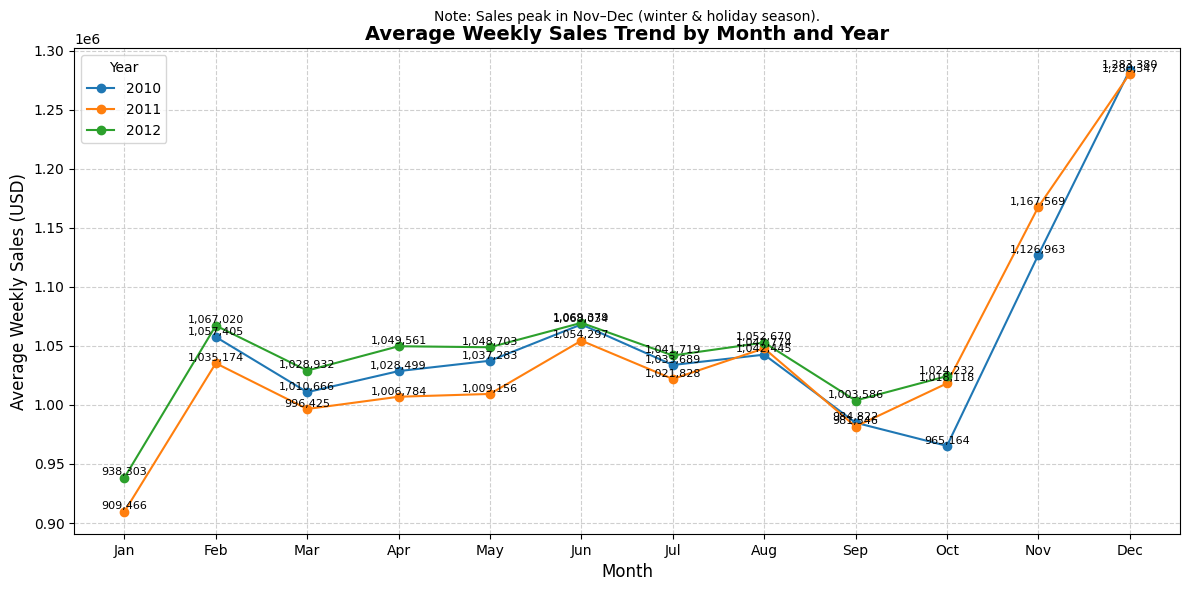

In [17]:
seasonal_trends['Weekly_Sales'] = (
    seasonal_trends['Weekly_Sales']
    .replace(',', '', regex=True)
    .astype(float)
)
seasonal_trends = seasonal_trends.sort_values(['Year', 'Month'])
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonal_trends['Month_Name'] = pd.Categorical(
    seasonal_trends['Month_Name'],
    categories=month_order,
    ordered=True
)
plt.figure(figsize=(12,6))
for year in seasonal_trends['Year'].unique():
    data = seasonal_trends[seasonal_trends['Year'] == year]
    plt.plot(
        data['Month'],
        data['Weekly_Sales'],
        marker='o',
        label=str(year)
    )
for i in range(len(seasonal_trends)):
    plt.text(
        x=seasonal_trends['Month'].iloc[i],
        y=seasonal_trends['Weekly_Sales'].iloc[i] + 2000,
        s=f"{seasonal_trends['Weekly_Sales'].iloc[i]:,.0f}",
        fontsize=8,
        ha='center'
    )
plt.xticks(ticks=range(1,13), labels=month_order)
plt.title('Average Weekly Sales Trend by Month and Year', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Weekly Sales (USD)', fontsize=12)
plt.legend(title='Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.text(
    0.5, 1.05,
    "Note: Sales peak in Nov–Dec (winter & holiday season).",
    fontsize=10,
    ha='center',
    va='bottom',
    transform=plt.gca().transAxes
)
plt.tight_layout()
plt.show()

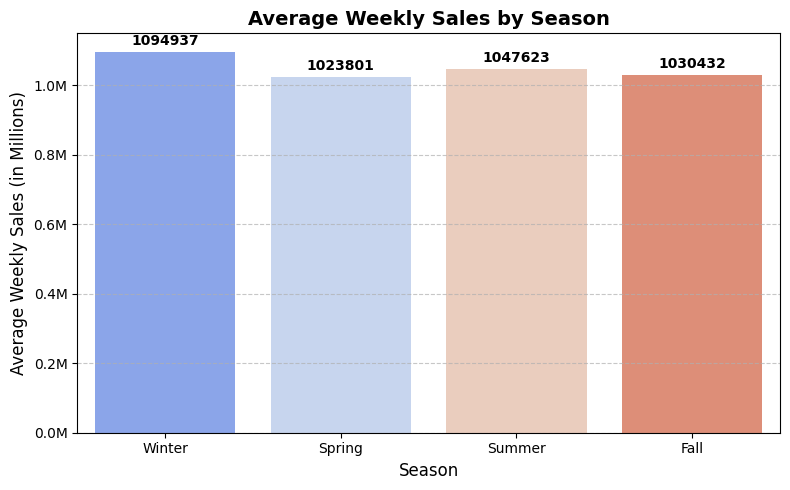

In [18]:
seasonal_sales = (
    df.groupby('Season', observed=True)['Weekly_Sales']
      .mean()
      .reindex(['Winter','Spring','Summer','Fall'])
      .reset_index()
)
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='Season', 
    y='Weekly_Sales', 
    hue='Season', 
    data=seasonal_sales, 
    palette='coolwarm', 
    legend=False
)
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.0f',  # tanpa desimal
        label_type='edge',
        padding=3,
        fontsize=10,
        fontweight='bold'
    )
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))
plt.title('Average Weekly Sales by Season', fontsize=14, fontweight='bold')
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Weekly Sales (in Millions)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Question 5 Do fuel prices, CPI, and unemployment influence revenue?

              Weekly_Sales  Fuel_Price  CPI  Unemployment  Temperature
Weekly_Sales             1           0   -0            -0           -0
Fuel_Price               0           1   -0            -0            0
CPI                     -0          -0    1            -0            0
Unemployment            -0          -0   -0             1            0
Temperature             -0           0    0             0            1


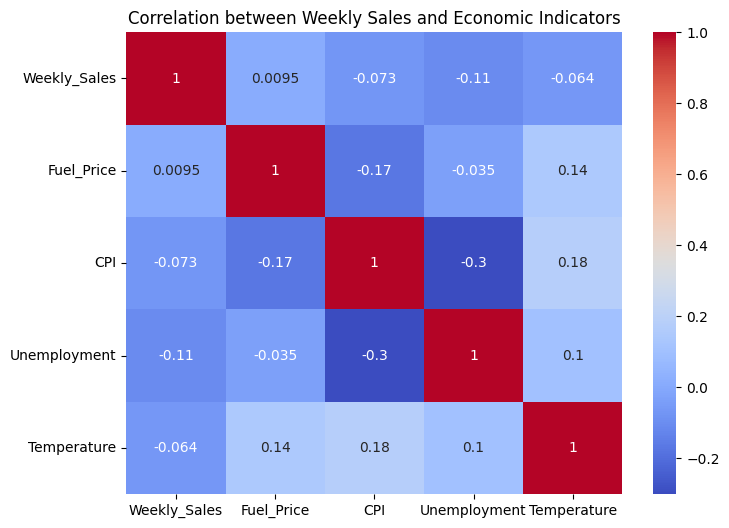

In [19]:
# correlation matrix
corr = df[['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment', 'Temperature']].corr()
print(corr)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Weekly Sales and Economic Indicators")
plt.show()

In [20]:
df['log_sales'] = np.log1p(df['Weekly_Sales'])
print(df.dtypes[df.dtypes == 'object'])
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except (ValueError, TypeError):
        pass
for col in df.select_dtypes(include='object').columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except Exception as e:
        print(f"Kolom {col} tidak bisa dikonversi:", e)
df = df.dropna(subset=['Fuel_Price', 'CPI', 'Unemployment', 'log_sales'])

Date       object
Holiday    object
Season     object
dtype: object


In [21]:
features = ['Fuel_Price', 'CPI', 'Unemployment']
X = df[features].astype(float)
X = sm.add_constant(X)
y = df['log_sales'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     41.62
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           1.25e-26
Time:                        16:38:12   Log-Likelihood:                -5658.9
No. Observations:                6435   AIC:                         1.133e+04
Df Residuals:                    6431   BIC:                         1.135e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.2958      0.081    175.865   